#Requirements

In [ ]:
!git clone https://github.com/ultralytics/yolov5 #git reposunu colaba çekiyoruz.

Cloning into 'yolov5'...
remote: Enumerating objects: 11205, done.
remote: Total 11205 (delta 0), reused 0 (delta 0), pack-reused 11205
Receiving objects: 100% (11205/11205), 11.11 MiB | 14.55 MiB/s, done.
Resolving deltas: 100% (7752/7752), done.


In [ ]:
%cd /content/yolov5
!pip install -r requirements.txt

/content/yolov5
     |████████████████████████████████| 596 kB 4.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

#Dataset

In [ ]:
!mkdir annotations
!gdown https://drive.google.com/uc?id=1FUQThhH4tbsFqyR7MycAFP_PKwtK0SCX
!unzip -q xml_format2.zip
!mv xml_format annotations
!mv /content/yolov5/annotations/xml_format/images/*.jpg /content/yolov5/annotations
!mv /content/yolov5/annotations/xml_format/xml/*.xml /content/yolov5/annotations
!rm -r /content/yolov5/annotations/xml_format
!rm -r xml_format2.zip
!rm -r /content/sample_data

#işletim sistemi komutlar

Downloading...
From: https://drive.google.com/uc?id=1o2d2mn5lpEiHO6rAzhbwIa1jHpaBbK_I
To: /content/yolov5/xml_format2.zip
100% 3.99M/3.99M [00:00<00:00, 126MB/s]


In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
extract_info_from_xml("/content/yolov5/annotations/3_labeling1008.xml")

{'bboxes': [{'class': 'hedef',
   'xmax': 102,
   'xmin': 20,
   'ymax': 157,
   'ymin': 18}],
 'filename': '3_labeling1008.jpg',
 'image_size': (224, 224, 3)}

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"hedef": 0
                            }
#class                     

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
###XML2TXT
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 901/901 [00:00<00:00, 1976.63it/s]


In [ ]:
!rm -r /content/yolov5/annotations/*.xml

a


In [ ]:
!mkdir images #dosyayı yeniden taşımam gerekti

In [ ]:
!mv /content/yolov5/annotations/*.jpg /content/yolov5/images

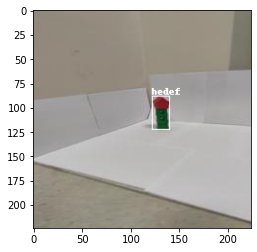

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
#SPLİT Section - @v01dString
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [ ]:
#Optional
import os
os.rename("/content/yolov5/annotations","/content/yolov5/labels")

#Train & Config

In [ ]:
#My Config File
import shutil
shutil.copy("/content/drive/MyDrive/road_sign_data.yaml","/content/yolov5/data")

'/content/yolov5/data/road_sign_data.yaml'

In [ ]:
!ls

annotations	 Dockerfile  LICENSE	       setup.cfg       val.py
CONTRIBUTING.md  export.py   models	       train.py
data		 hubconf.py  README.md	       tutorial.ipynb
detect.py	 images      requirements.txt  utils


In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.VOC.yaml --batch 32 --epochs 100 --data road_sign_data.yaml --weights yolov5s.pt --workers 24 --name Hedef

      1/99     7.14G   0.03827    0.0122         0        63       640:  52% 12/23 [00:28<00:26,  2.40s/it]
Traceback (most recent call last):
  File "train.py", line 643, in <module>
    main(opt)
  File "train.py", line 539, in main
    train(opt.hyp, opt, device, callbacks)
  File "train.py", line 331, in train
    loss, loss_items = compute_loss(pred, targets.to(device))  # loss scaled by batch_size
KeyboardInterrupt
^C


In [ ]:
!rm -r /content/yolov5/runs/train/Hedef

In [ ]:
%cd ..
!ls
!zip -r yolov5.zip yolov5

/content
drive  yolov5
  adding: yolov5/ (stored 0%)
  adding: yolov5/tutorial.ipynb (deflated 78%)
  adding: yolov5/.dockerignore (deflated 56%)
  adding: yolov5/README.md (deflated 72%)
  adding: yolov5/utils/ (stored 0%)
  adding: yolov5/utils/general.py (deflated 65%)
  adding: yolov5/utils/metrics.py (deflated 66%)
  adding: yolov5/utils/benchmarks.py (deflated 61%)
  adding: yolov5/utils/plots.py (deflated 65%)
  adding: yolov5/utils/datasets.py (deflated 71%)
  adding: yolov5/utils/autoanchor.py (deflated 61%)
  adding: yolov5/utils/loss.py (deflated 69%)
  adding: yolov5/utils/flask_rest_api/ (stored 0%)
  adding: yolov5/utils/flask_rest_api/README.md (deflated 52%)
  adding: yolov5/utils/flask_rest_api/restapi.py (deflated 45%)
  adding: yolov5/utils/flask_rest_api/example_request.py (deflated 29%)
  adding: yolov5/utils/augmentations.py (deflated 63%)
  adding: yolov5/utils/callbacks.py (deflated 69%)
  adding: yolov5/utils/torch_utils.py (deflated 62%)
  adding: yolov5/utils

In [ ]:
!cd /content/yolov5/runs/train
!mkdir Hedef

In [ ]:
!zip -r temp.zip /content/yolov5/runs/train/yolo_road_det4
shutil.copy("/content/yolov5/runs/train/temp.zip","/content/drive/MyDrive")

	zip warning: name not matched: /content/yolov5/runs/train/yolo_road_det4

zip error: Nothing to do! (try: zip -r temp.zip . -i /content/yolov5/runs/train/yolo_road_det4)


FileNotFoundError: ignored

#İnference

In [ ]:
!python detect.py --source 0 --weights /content/yolo_road_det4/weights/best.pt --conf 0.25 --name yolo_road_det

detect: weights=['/content/yolo_road_det4/weights/best.pt'], source=0, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_road_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-14-g8a66eba torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Traceback (most recent call last):
  File "detect.py", line 257, in <module>
    main(opt)
  File "detect.py", line 252, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 28, in decorate_context
    return func(*args, **kwargs)
  File "detect.py", line 92, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data)
  File "/content/yolov5/models/common.py", line 305, in __init_

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
!python detect.py --source 0 --weights C:/Users/Emre/Desktop/content/yolov5/runs/train/yolo_road_det4/weights/best.pt --conft 0.25 --name yolo_road_det_4

In [ ]:
!ls

CONTRIBUTING.md  export.py   LICENSE	  requirements.txt  tutorial.ipynb
data		 hubconf.py  models	  runs		    utils
detect.py	 images      __pycache__  setup.cfg	    val.py
Dockerfile	 labels      README.md	  train.py


In [ ]:
!unzip "/content/yolo_road_det4.zip"

Archive:  /content/yolo_road_det4.zip
   creating: yolo_road_det4/
  inflating: yolo_road_det4/confusion_matrix.png  
  inflating: yolo_road_det4/events.out.tfevents.1646183643.db74ebf8ca5c.502.0  
  inflating: yolo_road_det4/F1_curve.png  
  inflating: yolo_road_det4/hyp.yaml  
  inflating: yolo_road_det4/labels.jpg  
  inflating: yolo_road_det4/labels_correlogram.jpg  
  inflating: yolo_road_det4/opt.yaml  
  inflating: yolo_road_det4/PR_curve.png  
  inflating: yolo_road_det4/P_curve.png  
  inflating: yolo_road_det4/results.csv  
  inflating: yolo_road_det4/results.png  
  inflating: yolo_road_det4/R_curve.png  
  inflating: yolo_road_det4/train_batch0.jpg  
  inflating: yolo_road_det4/train_batch1.jpg  
  inflating: yolo_road_det4/train_batch2.jpg  
  inflating: yolo_road_det4/val_batch0_labels.jpg  
  inflating: yolo_road_det4/val_batch0_pred.jpg  
  inflating: yolo_road_det4/val_batch1_labels.jpg  
  inflating: yolo_road_det4/val_batch1_pred.jpg  
   creating: yolo_road_det4/wei

In [ ]:
im

yolo_road_det4


In [ ]:
%cd content

[Errno 2] No such file or directory: 'content'
/root


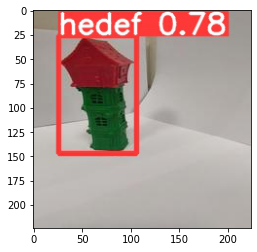

In [ ]:
#Test kümesinden rastgele bir veriyi görelim
detections_dir = "runs/detect/yolo_road_det10/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
#Bütün Test Verisetinin Başarımı Bir bakıma Modelin Başarımının İncelenmesi
!python test.py --weights runs/train/yolo_road_det/weights/best.pt --data road_sign_data.yaml --task test --name yolo_det

python3: can't open file 'test.py': [Errno 2] No such file or directory
